In [1]:
import numpy as np
import numpy.random as rnd
import os
import sys
import re

import tensorflow as tf
import cv2
import pandas as pd

# Ignore Warnings - obviously not a good choice
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

# Some Matplotlib magic
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
pylab.rcParams["figure.figsize"] = 8, 6

In [2]:
os.listdir("./DATA")

['t10k-images-idx3-ubyte',
 'fashion-mnist_test.csv',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'fashion-mnist_train.csv',
 'train-labels-idx1-ubyte']

In [3]:
train, test = pd.read_csv(os.path.join("DATA", "fashion-mnist_train.csv")), \
              pd.read_csv(os.path.join("DATA", "fashion-mnist_test.csv"))

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
def pandas_to_numpy_image(image):
    X = np.array(image[1:].as_matrix()).reshape((28, 28))
    return X, y

In [47]:
X_train, y_train = list(), list()
for iter, image in train.iterrows():
    X, y = pandas_to_numpy_image(image)
    X_train.append(X); y_train.append(y)
    
X_train, y_train = np.array(X_train), np.array(y_train).reshape((-1, 1)) # Reshaping y to 1-D array

X_test, y_test = list(), list()
for iter, image in test.iterrows():
    X, y = pandas_to_numpy_image(image)
    X_test.append(X); y_test.append(y)
    
X_test, y_test = np.array(X_test), np.array(y_test).reshape((-1, 1)) # Reshaping y to 1-D array

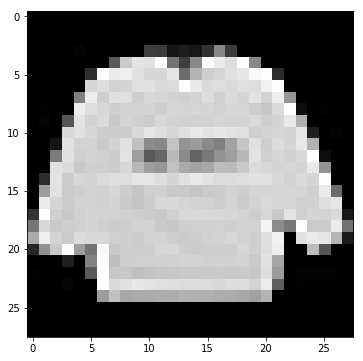

In [61]:
plt.imshow(X_train[0], cmap="gray", interpolation="nearest")